# Data cleaning and transformation


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType, TimestampType
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import lower, regexp_replace
# Download stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from pyspark.sql import SparkSession
import os

os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'


spark = SparkSession.builder \
    .appName("Reddit stocks Analysis") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

# !!!!!!!Read the CSV file with multiline support(your data will not show properly if you ain't using multiline cause of the \n in comment_body)
df = spark.read.csv(
    "full_dataset_updated.csv",
    header=True,
    inferSchema=True,
    multiLine=True,
    escape='"'
)


df.show(5, truncate=True)




+--------------------+----------+-------+-----------------+-------------------+--------------------+----------+--------------------+-------------+-------+
|          post_title|post_score|post_id|post_num_comments|       post_created|           post_body|comment_id|        comment_body|comment_score|company|
+--------------------+----------+-------+-----------------+-------------------+--------------------+----------+--------------------+-------------+-------+
|Tesla stands to e...|       548|1b3kl34|              175|2024-03-01 03:45:26|As of Thursday, o...|   kswcta9|It’s the country ...|            1|  tesla|
|Tesla stands to e...|       548|1b3kl34|              175|2024-03-01 03:45:26|As of Thursday, o...|   ksufbu2|https://en.wikipe...|            7|  tesla|
|Tesla stands to e...|       548|1b3kl34|              175|2024-03-01 03:45:26|As of Thursday, o...|   ksv9blq|    Very good point.|            1|  tesla|
|Tesla stands to e...|       548|1b3kl34|              175|2024-03-01 

In [ ]:
df.describe().show()

+-------+--------------------+------------------+-------+------------------+--------------------+----------+--------------------+------------------+--------------------+
|summary|          post_title|        post_score|post_id| post_num_comments|           post_body|comment_id|        comment_body|     comment_score|             company|
+-------+--------------------+------------------+-------+------------------+--------------------+----------+--------------------+------------------+--------------------+
|  count|               65952|             65952|  65952|             65952|               65689|     65951|               65949|             65951|               65951|
|   mean|                NULL| 947.3609898107715|   NULL|354.91366448326056|                NULL|      NULL|               809.0|12.031568892056223|                NULL|
| stddev|                NULL|1247.5277968613148|   NULL|253.23980226800538|                NULL|      NULL|  1107.3161246906866|62.998675061409685|  

In [ ]:

df = df.dropDuplicates()

# Drop rows with null values in important columns
df = df.na.drop(subset=["post_title", "post_body", "comment_body", "company"])


df.show(5)


+--------------------+----------+-------+-----------------+-------------------+--------------------+----------+--------------------+-------------+---------+
|          post_title|post_score|post_id|post_num_comments|       post_created|           post_body|comment_id|        comment_body|comment_score|  company|
+--------------------+----------+-------+-----------------+-------------------+--------------------+----------+--------------------+-------------+---------+
|    Google in Crisis|       718|1b4d5mn|              533|2024-03-02 02:30:14|https://www.bigte...|   ksz361o|The narrative at ...|           12|microsoft|
|Apple hit with mo...|      1687|1b6agqo|              411|2024-03-04 13:06:53|The European Comm...|   ktpih1p|           [deleted]|            1|     meta|
|Is Intel (INTC) U...|       213|1b9r14r|              235|2024-03-08 15:40:48|I was looking at ...|   ktzfm06|Lol do you how ma...|           16|    intel|
|Is Intel (INTC) U...|       213|1b9r14r|              235

In [ ]:
df.describe().show()

+-------+--------------------+------------------+-------+------------------+--------------------+----------+--------------------+------------------+--------------------+
|summary|          post_title|        post_score|post_id| post_num_comments|           post_body|comment_id|        comment_body|     comment_score|             company|
+-------+--------------------+------------------+-------+------------------+--------------------+----------+--------------------+------------------+--------------------+
|  count|               65686|             65686|  65686|             65686|               65686|     65686|               65686|             65686|               65686|
|   mean|                NULL| 934.5803672015346|   NULL|355.25411807691137|                NULL|      NULL|               809.0|11.994504156136772|                NULL|
| stddev|                NULL|1233.4956977526222|   NULL|253.69444376334363|                NULL|      NULL|  1107.3161246906866|62.488841968560074|  

In [ ]:

df = df.withColumn("post_created", to_timestamp("post_created"))


df = (
    df.dropna(subset=["comment_body"])
    .withColumn("post_created", col("post_created").cast(TimestampType()))
    .filter((col("comment_body") != "[removed]") & (col("comment_body") != "[deleted]"))
)


df.printSchema()


root
 |-- post_title: string (nullable = true)
 |-- post_score: integer (nullable = true)
 |-- post_id: string (nullable = true)
 |-- post_num_comments: integer (nullable = true)
 |-- post_created: timestamp (nullable = true)
 |-- post_body: string (nullable = true)
 |-- comment_id: string (nullable = true)
 |-- comment_body: string (nullable = true)
 |-- comment_score: integer (nullable = true)
 |-- company: string (nullable = true)



In [ ]:
# Initialize stop words and stemmer
stop_words = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")

# Define the text preprocessing function
def preprocess_text(text):
    if not text:
        return None

    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [stemmer.stem(token) for token in tokens]
    return " ".join(tokens)

# Create a UDF for the preprocessing function
preprocess_text_udf = udf(preprocess_text, StringType())


df = df.withColumn("post_body_processed", preprocess_text_udf(col("post_body")))
df = df.withColumn("comment_body_processed", preprocess_text_udf(col("comment_body")))


df.select("post_body", "post_body_processed").show(5, truncate=False)

df.drop("post_body", "comment_body").show(5)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from pyspark.sql.functions import year, month, dayofweek, size


df = df.withColumn("year", year(df["post_created"]))
df = df.withColumn("month", month(df["post_created"]))
df = df.withColumn("day_of_week", dayofweek(df["post_created"]))



df.show(5)


+--------------------+----------+-------+-----------------+-------------------+--------------------+----------+--------------------+-------------+---------+--------------------+----------------------+----+-----+-----------+
|          post_title|post_score|post_id|post_num_comments|       post_created|           post_body|comment_id|        comment_body|comment_score|  company| post_body_processed|comment_body_processed|year|month|day_of_week|
+--------------------+----------+-------+-----------------+-------------------+--------------------+----------+--------------------+-------------+---------+--------------------+----------------------+----+-----+-----------+
|    Google in Crisis|       718|1b4d5mn|              533|2024-03-02 02:30:14|https://www.bigte...|   ksz361o|The narrative at ...|           12|microsoft|httpswwwbigtechno...|  narrat time appl ...|2024|    3|          7|
|Is Intel (INTC) U...|       213|1b9r14r|              235|2024-03-08 15:40:48|I was looking at ...|   k

In [ ]:

pandas_df = df.select("year", "month", "day_of_week").toPandas()


<ipython-input-21-46cba5587028>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pandas_df, x="year", palette="viridis")


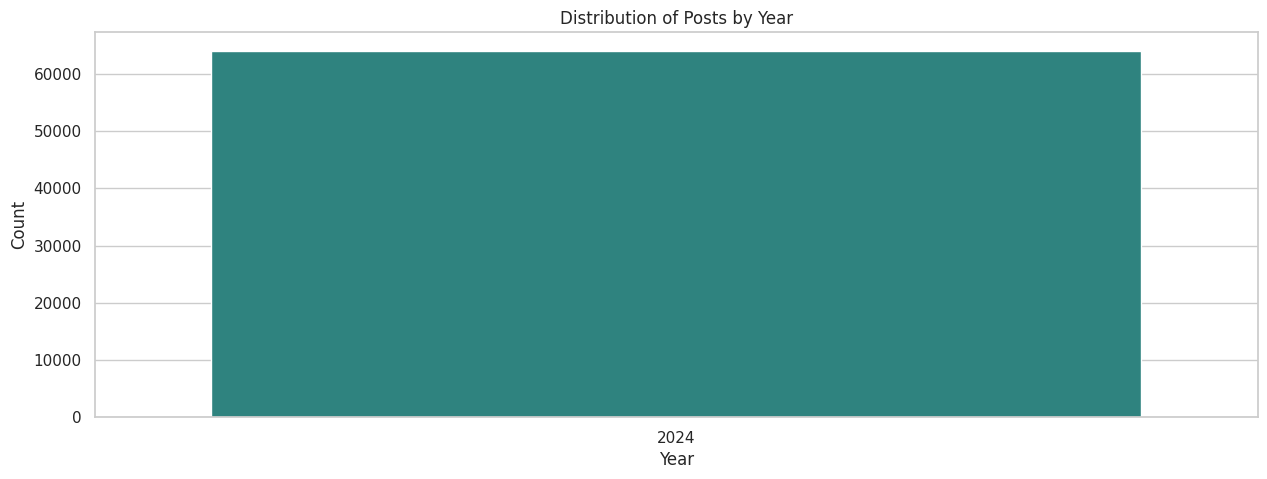

<ipython-input-21-46cba5587028>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pandas_df, x="month", palette="viridis")


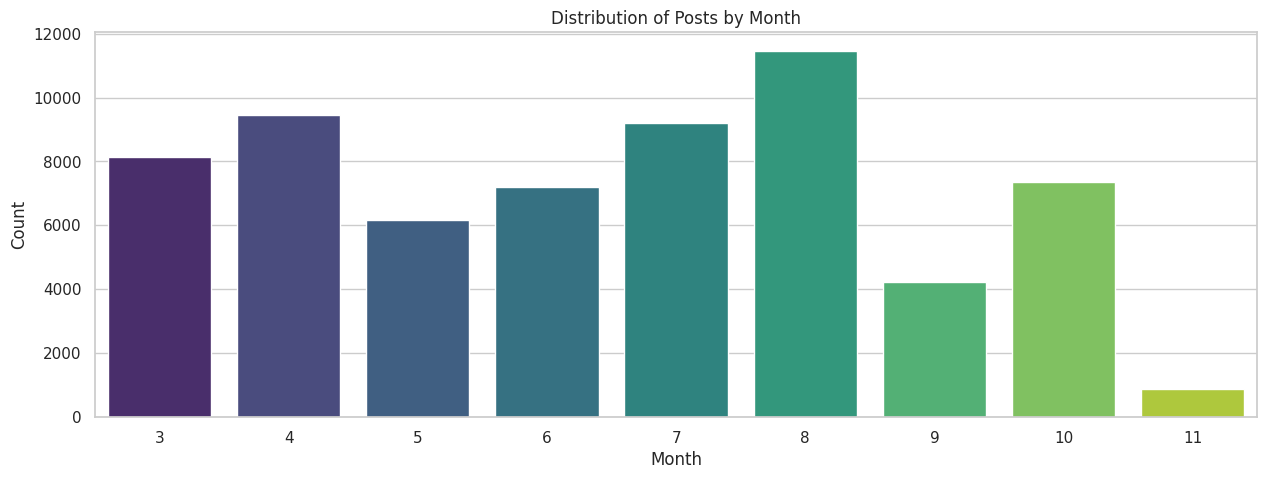

<ipython-input-21-46cba5587028>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pandas_df, x="day_of_week", palette="viridis")


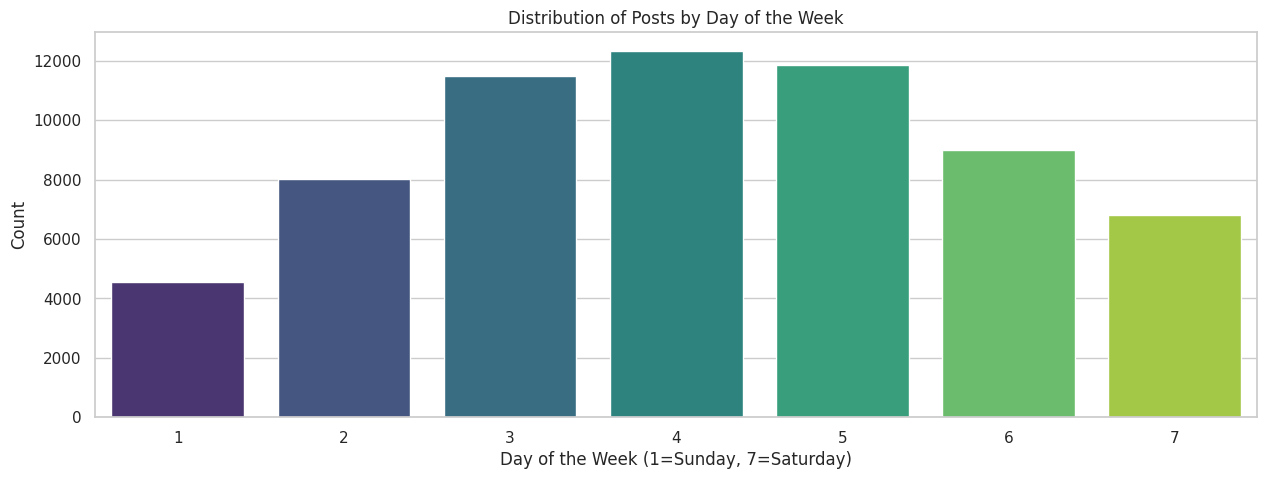

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")


plt.figure(figsize=(15, 5))
sns.countplot(data=pandas_df, x="year", palette="viridis")
plt.title("Distribution of Posts by Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()


plt.figure(figsize=(15, 5))
sns.countplot(data=pandas_df, x="month", palette="viridis")
plt.title("Distribution of Posts by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()


plt.figure(figsize=(15, 5))
sns.countplot(data=pandas_df, x="day_of_week", palette="viridis")
plt.title("Distribution of Posts by Day of the Week")
plt.xlabel("Day of the Week (1=Sunday, 7=Saturday)")
plt.ylabel("Count")
plt.show()


In [ ]:
from pyspark.sql import functions as F

keywords = ["Uber", "youtube", "meta", "apple", "nvidia", "microsoft", "amazon", "Saudi Arabian Oil Co", "intel", "tesla", "MARA Holdings"]

# Filter the DataFrame for each company and create separate DataFrames
company_dfs = {}
for company_name in keywords:
    # Filter the main DataFrame for rows matching the current company name
    company_df = df.filter(F.col("company") == company_name)

    # Add the filtered DataFrame to the dictionary
    company_dfs[company_name] = company_df

    # Optionally, create a globally accessible variable (like in pandas)
    globals()[company_name] = company_df

    # Print confirmation
    print(f"DataFrame for {company_name} created.")

# Example: Show the DataFrame for "tesla"
company_dfs["tesla"].show(truncate=False)

DataFrame for Uber created.
DataFrame for youtube created.
DataFrame for meta created.
DataFrame for apple created.
DataFrame for nvidia created.
DataFrame for microsoft created.
DataFrame for amazon created.
DataFrame for Saudi Arabian Oil Co created.
DataFrame for intel created.
DataFrame for tesla created.
DataFrame for MARA Holdings created.
+---------------------------------------------------------------------------------------------------------------------------+----------+-------+-----------------+-------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
!pip install praw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 6.7 MB/s eta 0:00:00


# Using VADER (Better for Social Media)


In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

# Download the VADER lexicon (only required once)
nltk.download('vader_lexicon')

# Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Define a function to calculate sentiment
def analyze_sentiment_vader(text):
    if text is None:  # Handle missing or null values
        return 0.0
    scores = sia.polarity_scores(text)
    return scores['compound']

# Register the function as a Spark UDF
analyze_sentiment_udf = udf(analyze_sentiment_vader, FloatType())

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
def classify_sentiment(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    else:
        return 'neutral'


classify_sentiment_udf = udf(classify_sentiment, StringType())

# Transform logic for PySpark
for company in keywords:
    if company in globals():
        df = globals()[company]
        if df is None:
            print(f"{company} DataFrame is None.")
            continue

        # Apply sentiment score and classification
        df = df.withColumn("sentiment_score", analyze_sentiment_udf(df["comment_body_processed"]))
        df = df.withColumn("sentiment", classify_sentiment_udf(df["sentiment_score"]))

        # Replace the DataFrame in the global scope
        globals()[company] = df

In [ ]:
# Select specific columns and show the top rows
globals()['meta'].select("comment_body_processed", "sentiment_score", "sentiment").show(5, truncate=False)


+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+---------+
|comment_body_processed                                                                                                                                                                                                                                                                                                                                                                                                 

# Using Hugging Face Transformers (Advanced Model)

In [ ]:
!pip install transformers torch

In [ ]:
!pip install emoji==0.6.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49719 sha256=0e69c96ba2fbc8f33fddf7a4e9c123a47768f1bd4b897de5edbb15d4ff923d87
  Stored in directory: /root/.cache/pip/wheels/1b/bd/d9/310c33c45a553798a714e27e3b8395d37128425442b8c78e07
Successfully built emoji


In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, FloatType, StructType, StructField
from transformers import pipeline

# Initialize the sentiment analysis model using transformers pipeline
sentiment_analyzer = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis", device=0)

# Define UDF to analyze sentiment and return a StructType (for label and score)
def analyze_sentiment_hugging(text):
    if text is None or text == '':
        return ('neutral', 0.0)  # Default to neutral if text is None or empty
    result = sentiment_analyzer(text[:128])  # Limit to first 128 characters for prediction
    label = result[0]['label']
    score = result[0]['score']
    return (label, score)

# Define the schema for the UDF's return type: StructType with two fields (sentiment and confidence)
sentiment_schema = StructType([
    StructField("sentiment", StringType(), False),
    StructField("confidence", FloatType(), False)
])

# Register the function as a UDF
analyze_sentiment_udf = udf(analyze_sentiment_hugging, sentiment_schema)

# Loop through the company names and apply the sentiment analysis
for company in keywords:
    if company in globals():
        df = globals()[company]
        if df is None:
            print(f"{company} DataFrame is None.")
            continue

        # Apply the sentiment analysis UDF, and create a new column 'sentiment_results' as a struct (sentiment, confidence)
        df = df.withColumn("sentiment_results", analyze_sentiment_udf(df["comment_body_processed"]))

        # Extract sentiment label and confidence score into separate columns
        df = df.withColumn("sentiment", df["sentiment_results"].getItem("sentiment"))
        df = df.withColumn("confidence", df["sentiment_results"].getItem("confidence"))

        # Update the global DataFrame for the company
        globals()[company] = df

# Optionally, show the transformed dataframe for a specific company
df.show(5, truncate=False)


+-------------------------------------------+----------+-------+-----------------+-------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:

df_uber = globals()['Uber']

df_uber.select('comment_body_processed', 'sentiment', 'confidence').show(5, truncate=False)


+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+----------+
|comment_body_processed                                                                                                                                                                                                                                                                                                                                                                                                         |sentiment|confidence|
+-------------------------------------------------------------------------------------------------------------------------

In [ ]:
for company in keywords:
    if company in globals():
        df = globals()[company]
        if df is None:
            print(f"{company} DataFrame is None.")
            continue

        # Get the number of rows in the DataFrame
        num_comments = df.count()
        print(f"{company}: {num_comments} comments")

        # Get the count of each unique sentiment value
        sentiment_counts = df.groupBy('sentiment').count().collect()

        # Print the sentiment counts
        for row in sentiment_counts:
            print(f"Sentiment: {row['sentiment']}, Count: {row['count']}")

Uber: 1065 comments
Sentiment: NEG, Count: 202
Sentiment: neutral, Count: 7
Sentiment: POS, Count: 95
Sentiment: NEU, Count: 761
youtube: 1857 comments
Sentiment: NEG, Count: 391
Sentiment: neutral, Count: 22
Sentiment: POS, Count: 209
Sentiment: NEU, Count: 1235
meta: 6425 comments
Sentiment: NEG, Count: 1444
Sentiment: neutral, Count: 43
Sentiment: POS, Count: 589
Sentiment: NEU, Count: 4349
apple: 7134 comments
Sentiment: NEG, Count: 1630
Sentiment: neutral, Count: 43
Sentiment: POS, Count: 666
Sentiment: NEU, Count: 4795
nvidia: 8009 comments
Sentiment: NEG, Count: 1301
Sentiment: neutral, Count: 65
Sentiment: POS, Count: 865
Sentiment: NEU, Count: 5778
microsoft: 3905 comments
Sentiment: NEG, Count: 788
Sentiment: neutral, Count: 30
Sentiment: POS, Count: 378
Sentiment: NEU, Count: 2709
amazon: 2823 comments
Sentiment: NEG, Count: 625
Sentiment: neutral, Count: 21
Sentiment: POS, Count: 274
Sentiment: NEU, Count: 1903
Saudi Arabian Oil Co: 0 comments
intel: 7678 comments
Sentiment

# Loading it into elasticsearch

In [ ]:
df.columns

['post_title',
 'post_score',
 'post_id',
 'post_num_comments',
 'post_created',
 'post_body',
 'comment_id',
 'comment_body',
 'comment_score',
 'company',
 'post_body_processed',
 'comment_body_processed',
 'year',
 'month',
 'day_of_week',
 'sentiment_score',
 'sentiment',
 'sentiment_results',
 'confidence']

In [ ]:
from elasticsearch import Elasticsearch, helpers
import elasticsearch as es


es = Elasticsearch(
    "https://ae9b-105-158-175-234.ngrok-free.app/",
    timeout=30,
    max_retries=10,
    retry_on_timeout=True
)



def create_index(index_name):
    if not es.indices.exists(index=index_name):
        es.indices.create(
            index=index_name,
            body={
                "mappings": {
                    "properties": {
                        "post_title": {"type": "text"},
                        "post_score": {"type": "float"},
                        "post_id": {"type": "keyword"},
                        "post_num_comments": {"type": "integer"},
                        "post_created": {"type": "date"},
                        "post_body": {"type": "text"},
                        "comment_id": {"type": "keyword"},
                        "comment_body": {"type": "text"},
                        "comment_score": {"type": "float"},
                        "company": {"type": "keyword"},
                        "post_body_processed": {"type": "text"},
                        "comment_body_processed": {"type": "text"},
                        "year": {"type": "integer"},
                        "month": {"type": "integer"},
                        "day_of_week": {"type": "integer"},
                        "sentiment_score": {"type": "float"},
                        "sentiment": {"type": "keyword"},
                        "sentiment_results": {"type": "text"},
                        "confidence": {"type": "float"}
                    }
                }
            }
        )
    else:
        print(f"Index '{index_name}' already exists.")

# Define the function to index DataFrame into Elasticsearch
def index_dataframe_to_elasticsearch(df, index_name):
    actions = []
    for _, row in df.iterrows():
        action = {
            "_op_type": "index",  # Use "index" to create new documents
            "_index": index_name,
            "_id": row.name,  # Use the index as document ID (optional)
            "_source": row.to_dict()  # Convert row to a dictionary for the document source
        }
        actions.append(action)

    # Bulk index the actions to Elasticsearch
    if actions:
        helpers.bulk(es, actions)
        print(f"Successfully indexed {len(actions)} documents to '{index_name}'.")

# Create the index (optional)
index_name = "reddit-company-sentiment"
create_index(index_name)

# Assuming you already have DataFrames stored in globals() for each company
for company in keywords:
    if company in globals():
        df = globals()[company]  # Get the PySpark DataFrame
        if df is None:
            print(f"{company} DataFrame is None.")
            continue

        # Convert PySpark DataFrame to pandas DataFrame for easier processing
        df_pandas = df.toPandas()

        # Index the DataFrame to Elasticsearch
        index_dataframe_to_elasticsearch(df_pandas, index_name)


ModuleNotFoundError: No module named 'elasticsearch'